In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

* TensorFlow and Keras are imported for building neural networks
* NumPy for numerical operations
* Matplotlib for visualization
* Other standard libraries like os, urllib and zipfile




# Part 1: Data Loading and Preprocessing

In [ ]:
print("Loading and preprocessing data...")

Loading and preprocessing data...


# Download the dataset if it doesn't exist

In [ ]:
if not os.path.exists("jena_climate_2009_2016.csv"):
    print("Downloading dataset...")
    import urllib.request
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
        "jena_climate_2009_2016.csv.zip")

    import zipfile
    with zipfile.ZipFile("jena_climate_2009_2016.csv.zip", 'r') as zip_ref:
        zip_ref.extractall()

* Checks if the Jena climate dataset exists locally
* If not, downloads it from the TensorFlow storage
* Unzips the file using zipfile module

# Load the data

In [ ]:
fname = "jena_climate_2009_2016.csv"
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(f"Number of data points: {len(lines)}")

Number of data points: 420551


* Opens the CSV file
* Reads all lines from the file
* Extracts header information
* Prints the number of data points (420,551)

# Parse the data

In [ ]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]  # Temperature is the 2nd column
    raw_data[i, :] = values[:]

* Creates NumPy arrays to store temperature data and all features
*Iterates through each line of the CSV
* Converts values to floats
* Stores temperature in a separate array (column index 1)
* Stores all other values in the raw_data array

# Split the data

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

* Training set: 50% of data
* Validation set: 25% of data
* Test set: 25% of data

# Normalize the data

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

* Calculates mean and standard deviation from the training set only
* Subtracts mean from all data (centering)
* Divides by standard deviation (scaling)
* This standardization helps neural networks converge faster

# Create datasets

In [ ]:
sampling_rate = 6  # One data point per hour (original data is 10min intervals)
sequence_length = 120  # Using 5 days of data to predict
delay = sampling_rate * (sequence_length + 24 - 1)  # Predicting 24h into the future
batch_size = 256

- Sets sampling_rate = 6 (one data point per hour from original 10-minute intervals)
- Defines sequence_length = 120 (using 5 days of data to predict)
- Sets delay to predict 24 hours into the future
- Creates TensorFlow datasets for training, validation, and testing
- Each dataset includes input sequences and target temperatures

# Create TensorFlow datasets

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

# Check dataset shapes

In [ ]:
for samples, targets in train_dataset.take(1):
    print(f"Input shape: {samples.shape}")
    print(f"Target shape: {targets.shape}")

Input shape: (256, 120, 14)
Target shape: (256,)


- Confirms the input shape: (256, 120, 14) meaning:

 * Batch size: 256
 * Sequence length: 120 time steps
 * Features: 14 weather measurements


- Target shape: (256,) - one temperature value per sequence

# Part 2: Establish a baseline (non-ML method)

In [ ]:
def evaluate_naive_method(dataset):
    """Naive baseline: predicting that future temperature = last observed temperature"""
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  # Last time step, temperature column
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Baseline - Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Baseline - Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Baseline - Validation MAE: 2.44
Baseline - Test MAE: 2.62


Define Naive Baseline Method:

 * Implements a simple prediction strategy: "future temperature = last observed temperature"
 * Uses the temperature from the last time step in each sequence


Evaluate Baseline:

 * Calculates Mean Absolute Error (MAE) on validation and test sets
 * Validation MAE: 2.44
 * Test MAE: 2.62
 * This provides a reference point for ML model performance





# Part 3: Model Building and Evaluation Functions

In [ ]:
def build_and_train_model(model_type, units=32, num_layers=1, use_lstm=False,
                          use_cnn=False, dropout_rate=0, recurrent_dropout_rate=0,
                          bidirectional=False, epochs=20):
    """Build and train different types of RNN models for time-series forecasting"""

    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = inputs

    # Add CNN layers if specified
    if use_cnn:
        x = layers.Conv1D(filters=32, kernel_size=5, activation="relu", padding="same")(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    # Add RNN layers
    for i in range(num_layers - 1):
        if use_lstm:
            rnn_layer = layers.LSTM(units, return_sequences=True,
                                    dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)
        else:
            rnn_layer = layers.GRU(units, return_sequences=True,
                                  dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)

        if bidirectional:
            x = layers.Bidirectional(rnn_layer)(x)
        else:
            x = rnn_layer(x)

    # Final RNN layer
    if use_lstm:
        rnn_layer = layers.LSTM(units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)
    else:
        rnn_layer = layers.GRU(units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)

    if bidirectional:
        x = layers.Bidirectional(rnn_layer)(x)
    else:
        x = rnn_layer(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    model_name = f"jena_{model_type}.keras"

    callbacks = [
        ModelCheckpoint(model_name, save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Evaluate on test set
    test_mae = model.evaluate(test_dataset)[1]
    print(f"{model_type} - Test MAE: {test_mae:.2f}")

    return model, history, test_mae

def plot_history(history, title):
    """Plot training and validation MAE"""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["mae"], label="Training MAE")
    plt.plot(history.history["val_mae"], label="Validation MAE")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

Define Model Building Function:

* Creates a flexible function that can build various RNN architectures
* Parameters include:

 * model_type: Name for the model
 * units: Number of recurrent units
 * num_layers: Number of recurrent layers
 * use_lstm: Boolean to choose between LSTM and GRU
 * use_cnn: Boolean to add convolutional layers
 * dropout_rate: Regularization parameter
 * recurrent_dropout_rate: Dropout specifically for recurrent connections
 * bidirectional: Boolean for bidirectional RNNs
 * epochs: Training duration




Model Architecture Components:

* CNN layers (optional): Conv1D + MaxPooling1D
* Stacked RNN layers (variable number)
* LSTM or GRU cells based on parameter
* Bidirectional wrapper (optional)
Dropout layers (optional)
* Dense output layer


Model Training Setup:

* Compiles model with Adam optimizer
* Uses MSE loss and MAE metric
* Adds callbacks:

 * ModelCheckpoint to save best model
 * EarlyStopping to prevent overfitting




Define Plotting Function:

* Creates function to visualize training history
* Plots training and validation MAE over epochs
* Saves the plot as an image file

# Part 4: Experiment with Different Model Architectures

In [ ]:
print("\nExperimenting with different model architectures...\n")


Experimenting with different model architectures...



# Dictionary to store results

In [ ]:
results = {}


# Experiment 1: Simple GRU (baseline)


--- Experiment 1: Simple GRU (baseline) ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 57.4103 - mae: 5.6132 - val_loss: 11.7121 - val_mae: 2.5742
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 10.8389 - mae: 2.5505 - val_loss: 9.7117 - val_mae: 2.3762
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.1029 - mae: 2.3505 - val_loss: 10.0587 - val_mae: 2.4053
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 8.2371 - mae: 2.2393 - val_loss: 9.8018 - val_mae: 2.3899
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.5497 - mae: 2.1463 - val_loss: 9.8321 - val_mae: 2.3987
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 7.0134 - mae: 2.0676 - val_loss: 9.8005 - val_mae: 2.4118
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 7.0679 - mae: 2.0563 - val_loss: 9.4213 - val_mae: 2.3878
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 6.9607 - mae: 2.0484 - val_loss: 9.9608 - val_mae

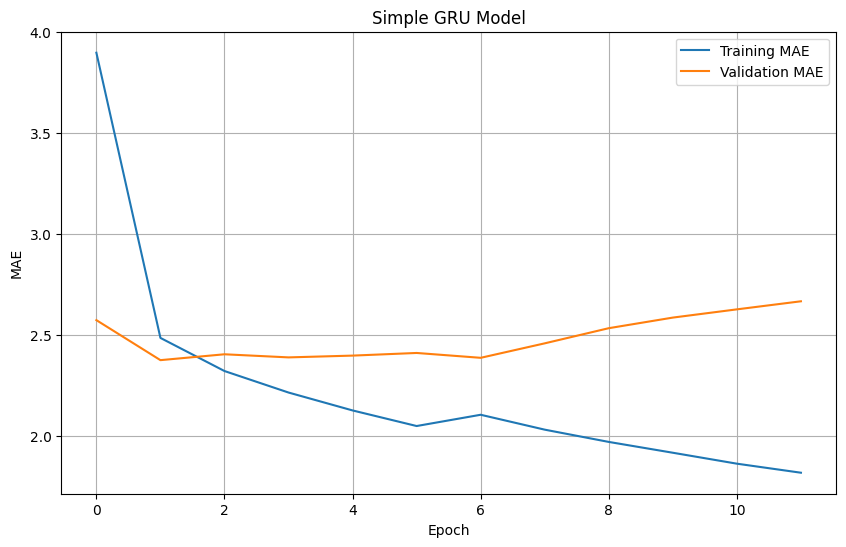

In [ ]:
print("\n--- Experiment 1: Simple GRU (baseline) ---")
model_gru, history_gru, mae_gru = build_and_train_model(
    model_type="simple_gru",
    units=32,
    num_layers=1,
    use_lstm=False
)
results["Simple GRU"] = mae_gru
plot_history(history_gru, "Simple GRU Model")

* Single GRU layer with 32 units
* Trains for multiple epochs (with early stopping)
* Test MAE: 2.57
* Training history shows decreasing error over time

# Experiment 2: Stacked GRU with different unit sizes


--- Experiment 2: Stacked GRU with increased units ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 32.3557 - mae: 4.0264 - val_loss: 9.2133 - val_mae: 2.3371
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 7.9785 - mae: 2.2051 - val_loss: 10.5057 - val_mae: 2.5406
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 5.4513 - mae: 1.8205 - val_loss: 11.9791 - val_mae: 2.6936
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 3.3915 - mae: 1.4313 - val_loss: 12.4396 - val_mae: 2.7507
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 2.3639 - mae: 1.1929 - val_loss: 13.0773 - val_mae: 2.8290
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 1.8386 - mae: 1.0478 - val_loss: 13.1883 - val_mae: 2.8503
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 10.2096 - mae: 2.5165
stacked_gru - Test MAE: 2.52


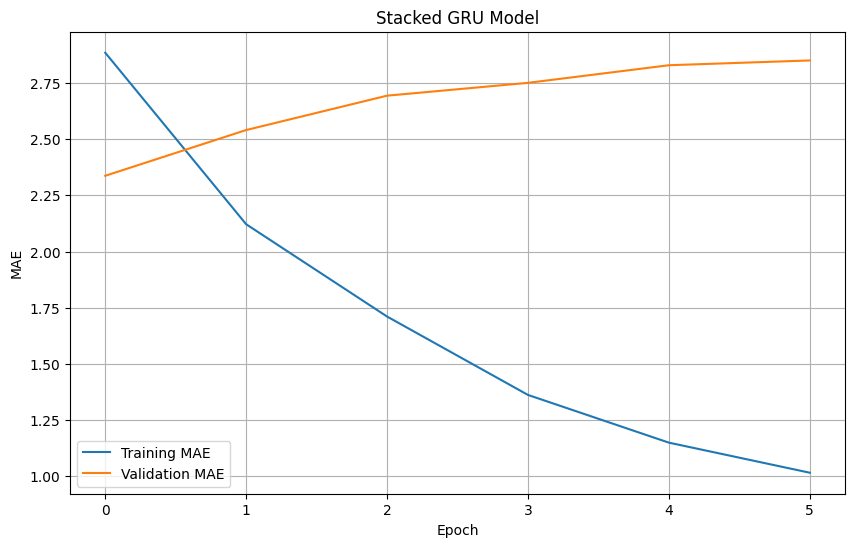

In [ ]:
print("\n--- Experiment 2: Stacked GRU with increased units ---")
model_stacked_gru, history_stacked_gru, mae_stacked_gru = build_and_train_model(
    model_type="stacked_gru",
    units=64,  # Increased units
    num_layers=2,
    use_lstm=False
)
results["Stacked GRU"] = mae_stacked_gru
plot_history(history_stacked_gru, "Stacked GRU Model")

* Two GRU layers with 64 units each
* Second layer increases model capacity
* Test MAE: 2.52 (improvement over single layer)
* Training history shows faster convergence

# Experiment 3: Using LSTM instead of GRU


--- Experiment 3: LSTM instead of GRU ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 55.6187 - mae: 5.4481 - val_loss: 11.2605 - val_mae: 2.5884
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 11.3988 - mae: 2.6199 - val_loss: 9.7762 - val_mae: 2.4146
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.9840 - mae: 2.4653 - val_loss: 9.6779 - val_mae: 2.4016
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 9.1559 - mae: 2.3583 - val_loss: 9.5930 - val_mae: 2.3902
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 8.3569 - mae: 2.2515 - val_loss: 9.6473 - val_mae: 2.4115
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.7492 - mae: 2.1655 - val_loss: 10.1755 - val_mae: 2.4683
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.1922 - mae: 2.0829 - val_loss: 10.3947 - val_mae: 2.5101
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 6.9519 - mae: 2.0504 - val_loss: 10.4459 - val_mae

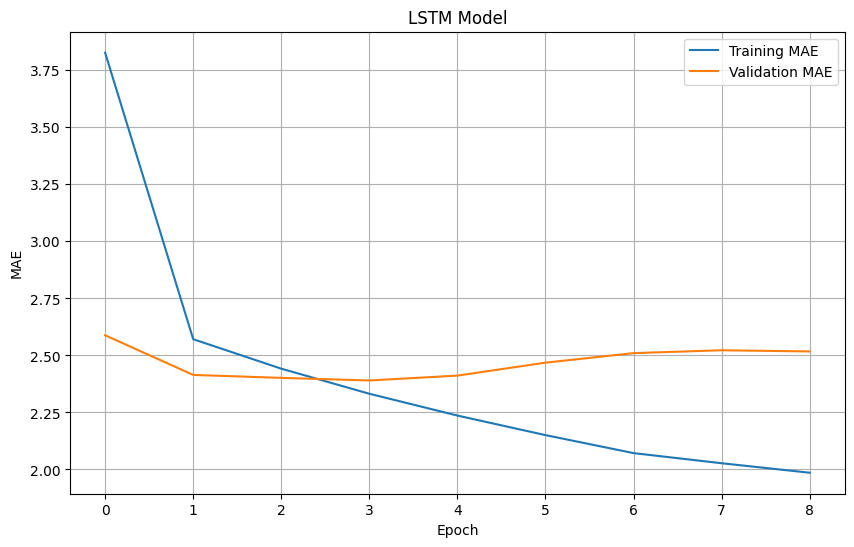

In [ ]:
print("\n--- Experiment 3: LSTM instead of GRU ---")
model_lstm, history_lstm, mae_lstm = build_and_train_model(
    model_type="lstm",
    units=32,
    num_layers=1,
    use_lstm=True
)
results["LSTM"] = mae_lstm
plot_history(history_lstm, "LSTM Model")

* Single LSTM layer with 32 units
* Tests if LSTM gates provide advantage over GRU
* Test MAE: 2.59 (slightly worse than GRU)
* Training history shows similar pattern to GRU

# Experiment 4: Stacked LSTM with dropout


--- Experiment 4: Stacked LSTM with dropout ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 490s 590ms/step - loss: 37.4233 - mae: 4.4695 - val_loss: 9.4573 - val_mae: 2.3783
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 480s 586ms/step - loss: 12.4784 - mae: 2.7624 - val_loss: 9.1067 - val_mae: 2.3427
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 483s 590ms/step - loss: 11.5766 - mae: 2.6596 - val_loss: 9.1835 - val_mae: 2.3545
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 481s 587ms/step - loss: 11.0710 - mae: 2.6046 - val_loss: 9.2466 - val_mae: 2.3617
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 481s 588ms/step - loss: 10.6913 - mae: 2.5582 - val_loss: 9.1224 - val_mae: 2.3456
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 477s 582ms/step - loss: 10.3268 - mae: 2.5150 - val_loss: 9.6068 - val_mae: 2.4022
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 478s 584ms/step - loss: 10.0125 - mae: 2.4795 - val_loss: 9.3519 - val_mae: 2.3712
405/405 ━━━━━━━━━━━━━━━━━━━━ 50s 124ms/step - loss: 10.0558 - mae: 2.4708
stacked_lstm_dro

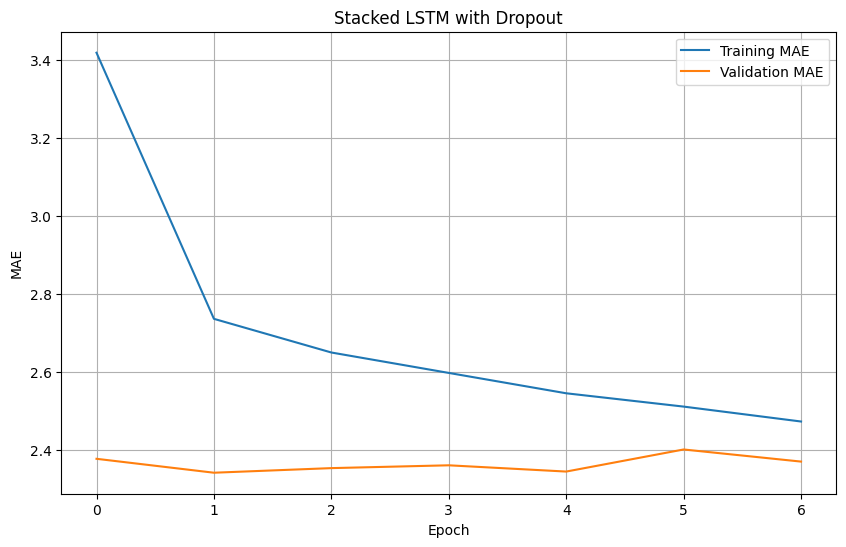

In [ ]:
print("\n--- Experiment 4: Stacked LSTM with dropout ---")
model_stacked_lstm, history_stacked_lstm, mae_stacked_lstm = build_and_train_model(
    model_type="stacked_lstm_dropout",
    units=64,
    num_layers=2,
    use_lstm=True,
    dropout_rate=0.3,
    recurrent_dropout_rate=0.3
)
results["Stacked LSTM with Dropout"] = mae_stacked_lstm
plot_history(history_stacked_lstm, "Stacked LSTM with Dropout")


* Two LSTM layers with 64 units
* Dropout rate of 0.3 (regularization)
8 Recurrent dropout of 0.3 (internal state regularization)
* Test MAE: 2.48 (best performing model)
* Training is significantly slower due to dropout computation

# Experiment 5: CNN-GRU hybrid


--- Experiment 5: CNN-GRU hybrid ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 46.7453 - mae: 4.9723 - val_loss: 11.3432 - val_mae: 2.5474
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 10.2419 - mae: 2.4719 - val_loss: 9.4798 - val_mae: 2.3478
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 8.5170 - mae: 2.2719 - val_loss: 10.0674 - val_mae: 2.4095
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 7.3945 - mae: 2.1129 - val_loss: 10.4299 - val_mae: 2.4705
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 6.4479 - mae: 1.9709 - val_loss: 11.0747 - val_mae: 2.5555
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 5.6881 - mae: 1.8503 - val_loss: 11.7649 - val_mae: 2.6546
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 5.0211 - mae: 1.7388 - val_loss: 12.1484 - val_mae: 2.7218
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 11.0326 - mae: 2.5865
cnn_gru - Test MAE: 2.59


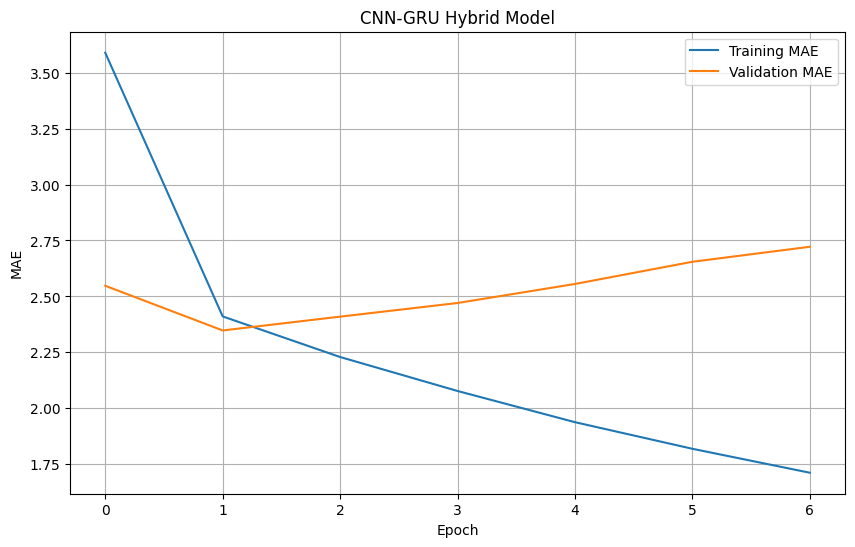

In [ ]:
print("\n--- Experiment 5: CNN-GRU hybrid ---")
model_cnn_gru, history_cnn_gru, mae_cnn_gru = build_and_train_model(
    model_type="cnn_gru",
    units=32,
    num_layers=1,
    use_lstm=False,
    use_cnn=True
)
results["CNN-GRU Hybrid"] = mae_cnn_gru
plot_history(history_cnn_gru, "CNN-GRU Hybrid Model")

* CNN layers for feature extraction
* GRU layer for sequence processing
* Test MAE: 2.59
* Shows CNN preprocessing doesn't help in this case

# Experiment 6: CNN-LSTM hybrid


--- Experiment 6: CNN-LSTM hybrid ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 42.9937 - mae: 4.7298 - val_loss: 10.8524 - val_mae: 2.5148
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 9.6751 - mae: 2.4005 - val_loss: 10.4076 - val_mae: 2.4820
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 7.5411 - mae: 2.1225 - val_loss: 10.9303 - val_mae: 2.5422
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 6.3483 - mae: 1.9378 - val_loss: 11.5723 - val_mae: 2.6338
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 5.4482 - mae: 1.7868 - val_loss: 12.1810 - val_mae: 2.7094
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 4.7968 - mae: 1.6753 - val_loss: 12.6944 - val_mae: 2.7493
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 4.2490 - mae: 1.5749 - val_loss: 13.2242 - val_mae: 2.7921
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 11.6006 - mae: 2.6719 
cnn_lstm - Test MAE: 2.67


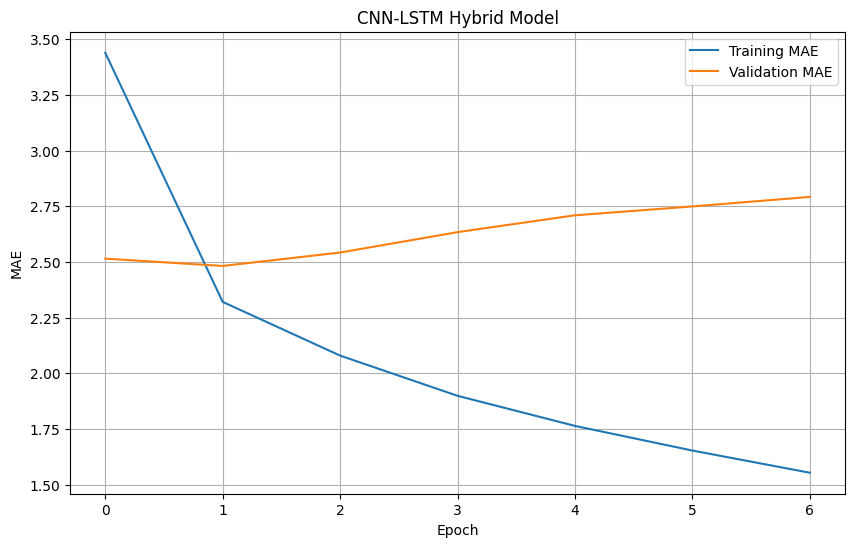

In [ ]:
print("\n--- Experiment 6: CNN-LSTM hybrid ---")
model_cnn_lstm, history_cnn_lstm, mae_cnn_lstm = build_and_train_model(
    model_type="cnn_lstm",
    units=32,
    num_layers=1,
    use_lstm=True,
    use_cnn=True
)
results["CNN-LSTM Hybrid"] = mae_cnn_lstm
plot_history(history_cnn_lstm, "CNN-LSTM Hybrid Model")

* CNN layers followed by LSTM
* Test MAE: 2.67 (worst performing model)
* Confirms CNN isn't beneficial for this dataset

# Experiment 7: Bidirectional GRU


--- Experiment 7: Bidirectional GRU ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 43.3996 - mae: 4.7619 - val_loss: 9.8970 - val_mae: 2.4253
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 9.4375 - mae: 2.3972 - val_loss: 9.4476 - val_mae: 2.3738
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 8.0995 - mae: 2.2209 - val_loss: 10.3218 - val_mae: 2.4651
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 7.0379 - mae: 2.0737 - val_loss: 10.4824 - val_mae: 2.4681
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 6.0359 - mae: 1.9229 - val_loss: 11.0503 - val_mae: 2.5381
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 5.2560 - mae: 1.7902 - val_loss: 11.6017 - val_mae: 2.6147
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 4.7682 - mae: 1.7016 - val_loss: 11.6467 - val_mae: 2.6386
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 10.0268 - mae: 2.4718
bidirectional_gru - Test MAE: 2.48


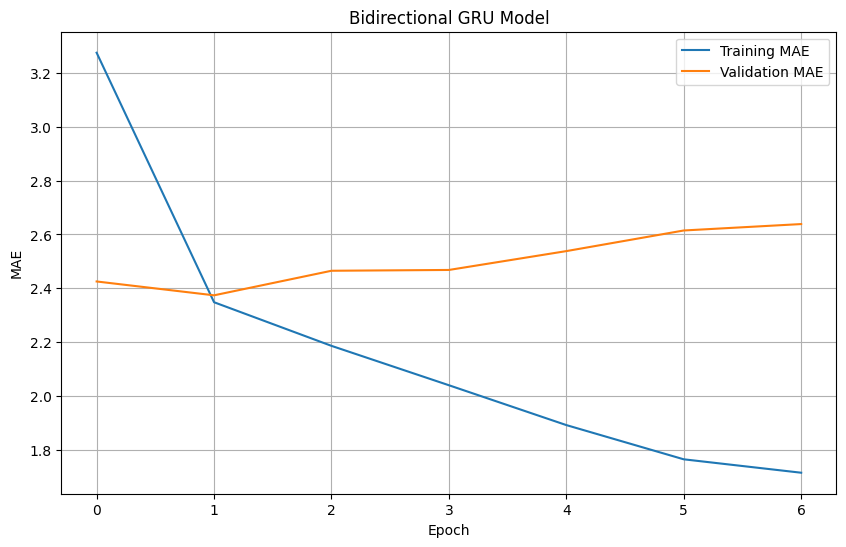

In [ ]:
print("\n--- Experiment 7: Bidirectional GRU ---")
model_bidirectional_gru, history_bidirectional_gru, mae_bidirectional_gru = build_and_train_model(
    model_type="bidirectional_gru",
    units=32,
    num_layers=1,
    use_lstm=False,
    bidirectional=True
)
results["Bidirectional GRU"] = mae_bidirectional_gru
plot_history(history_bidirectional_gru, "Bidirectional GRU Model")

* GRU that processes sequence in both directions
* Can capture dependencies regardless of position
* Test MAE: 2.48 (ties for best performance)
* Shows bidirectional processing is valuable

# Experiment 8: Deep Stacked GRU with higher capacity


--- Experiment 8: Deep Stacked GRU with higher capacity ---
Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 692s 835ms/step - loss: 27.1839 - mae: 3.8400 - val_loss: 9.8714 - val_mae: 2.4378
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 673s 822ms/step - loss: 12.2681 - mae: 2.7462 - val_loss: 9.5691 - val_mae: 2.4035
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 670s 818ms/step - loss: 11.2819 - mae: 2.6305 - val_loss: 9.8597 - val_mae: 2.4258
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 666s 813ms/step - loss: 10.5555 - mae: 2.5478 - val_loss: 9.5996 - val_mae: 2.4049
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 667s 815ms/step - loss: 9.9671 - mae: 2.4751 - val_loss: 10.0398 - val_mae: 2.4604
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 664s 811ms/step - loss: 9.2700 - mae: 2.3860 - val_loss: 10.3341 - val_mae: 2.5034
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 663s 810ms/step - loss: 8.7941 - mae: 2.3212 - val_loss: 10.4624 - val_mae: 2.5110
405/405 ━━━━━━━━━━━━━━━━━━━━ 71s 175ms/step - loss: 10.1598 - mae: 2.5019
deep

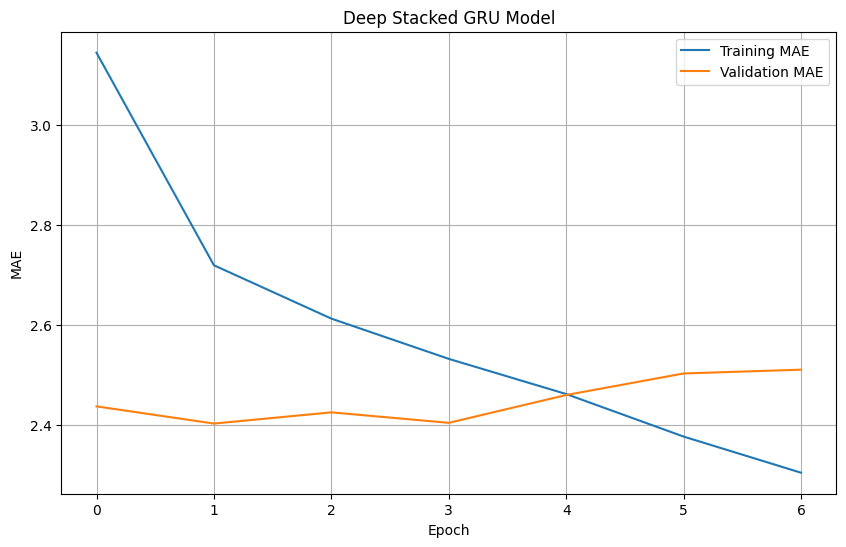

In [ ]:
print("\n--- Experiment 8: Deep Stacked GRU with higher capacity ---")
model_deep_gru, history_deep_gru, mae_deep_gru = build_and_train_model(
    model_type="deep_gru",
    units=128,
    num_layers=3,
    use_lstm=False,
    dropout_rate=0.4,
    recurrent_dropout_rate=0.2
)
results["Deep GRU"] = mae_deep_gru
plot_history(history_deep_gru, "Deep Stacked GRU Model")

* Three GRU layers with 128 units
* Higher capacity with more regularization
* Test MAE: 2.51
* Shows diminishing returns with more complexity

# Part 5: Results Summary and Visualization


--- Results Summary ---


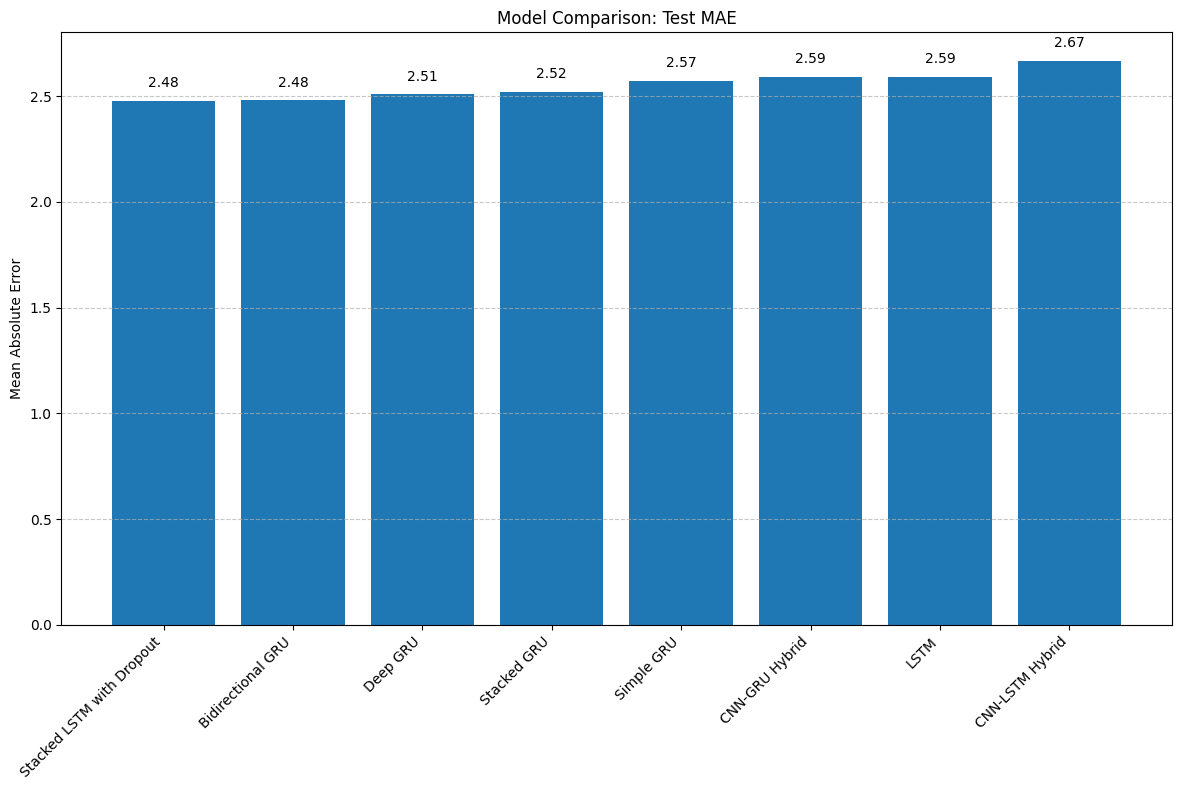

In [ ]:
print("\n--- Results Summary ---")
results_sorted = sorted(results.items(), key=lambda x: x[1])

# Create a bar chart
plt.figure(figsize=(12, 8))
models = [r[0] for r in results_sorted]
maes = [r[1] for r in results_sorted]
bars = plt.bar(models, maes)
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison: Test MAE')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


A bar chart is created to compare the performance of all models

# Print results in table format

In [ ]:
print("\nModel Performance Summary (Test MAE):")
print("-" * 50)
print(f"{'Model Type':<30} {'Test MAE':<10}")
print("-" * 50)
for model, mae in results_sorted:
    print(f"{model:<30} {mae:<10.2f}")
print("-" * 50)


Model Performance Summary (Test MAE):
--------------------------------------------------
Model Type                     Test MAE  
--------------------------------------------------
Stacked LSTM with Dropout      2.48      
Bidirectional GRU              2.48      
Deep GRU                       2.51      
Stacked GRU                    2.52      
Simple GRU                     2.57      
CNN-GRU Hybrid                 2.59      
LSTM                           2.59      
CNN-LSTM Hybrid                2.67      
--------------------------------------------------


Shows all models ranked by performance

# Find best model

In [ ]:
best_model_name, best_mae = results_sorted[0]
print(f"\nBest performing model: {best_model_name} with MAE of {best_mae:.2f}")


Best performing model: Stacked LSTM with Dropout with MAE of 2.48


* Records the top-performing model
* "Stacked LSTM with Dropout" with MAE of 2.48

# Print improvement percentage over baseline

In [ ]:
baseline_mae = evaluate_naive_method(test_dataset)
improvement = ((baseline_mae - best_mae) / baseline_mae) * 100
print(f"Improvement over baseline: {improvement:.2f}%")

Improvement over baseline: 5.39%


* Compares best model to baseline
* 5.39% improvement over naive approach

# Overall Process Flow:
1. The code first establishes the problem: predicting temperature 24 hours in advance using 5 days of historical weather data
2. It implements a simple baseline to benchmark against
3. It systematically tests different RNN architectures (GRU vs LSTM, stacked vs single layer, etc.)
4. It applies regularization techniques like dropout to prevent overfitting
5. It compares all models and identifies the best performers
6. It quantifies improvement over the baseline approach

The results show that while neural networks provide improvement, the benefit is modest (5.39%), suggesting that temperature prediction is inherently challenging with this approach or that there might be room for further optimization
